# **Enhancing Spinal Fracture Detection with Image Transformations and Deep Learning**

This notebook explores the impact of image preprocessing techniques on spinal fracture detection using deep learning. The workflow includes:

## **1. Dataset Preparation**
- Mounting Google Drive and verifying dataset paths.
- Splitting the data into training and testing sets while ensuring consistency.

## **2. Data Loading & Visualization**
- Defining a PyTorch dataset class and applying transformations.
- Displaying sample images to verify correctness.

## **3. Model Selection & Initialization**
- Loading and modifying pretrained models (ResNet, EfficientNet, DenseNet) for binary classification.

## **4. Training Baseline Models**
- Implementing a training pipeline with accuracy and F1-score tracking.
- Using model checkpointing and `tqdm` progress bars for efficient tracking.

## **5. Applying Image Transformations**
- Implementing **Histogram Equalization, CLAHE, and Unsharp Masking** to enhance image quality.
- Testing the effect of these transformations on model performance.

## **6. Retraining with Augmented Data**
- Re-training models on transformed images and analyzing their impact.

## **7. Learning Rate Scheduling**
- Integrating `ReduceLROnPlateau` to adapt learning rates based on validation loss for improved convergence.

## **8. Results Analysis**
- Summarizing training results into structured tables.
- Visualizing image transformations to evaluate their effectiveness.

This structured approach ensures fairness in experiments and helps determine which preprocessing methods improve model performance.


In [ ]:
import os
import torch
import numpy as np
import random

# Set CuBLAS workspace config BEFORE PyTorch initializes CUDA
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# Ensure PyTorch deterministic settings
torch.use_deterministic_algorithms(True)

# Print confirmation
print("✅ CuBLAS workspace config applied successfully.")

✅ CuBLAS workspace config applied successfully.


In [ ]:
import numpy as np
import random

# Set random seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

# Configure CuBLAS to avoid errors
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# Print confirmation
print("✅ PyTorch deterministic mode enabled.")
print("✅ CuBLAS workspace configured for reproducibility.")

✅ PyTorch deterministic mode enabled.
✅ CuBLAS workspace configured for reproducibility.


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
fractured_path = '/content/drive/MyDrive/FracAtlas/FracAtlas/images/Fractured'
non_fractured_path = '/content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured'

# Verify that the dataset directories exist
if not os.path.exists(fractured_path) or not os.path.exists(non_fractured_path):
    print("Error: One or both dataset directories do not exist. Check your paths!")
else:
    print("Dataset paths verified.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset paths verified.


We retrieve image file paths, count them, and print a few samples to verify dataset integrity before processing.

In [ ]:
import glob   # No rerun needed

# Get all image file paths
fractured_images = glob.glob(os.path.join(fractured_path, "*"))
non_fractured_images = glob.glob(os.path.join(non_fractured_path, "*"))

# Print dataset statistics
print(f"Total fractured images: {len(fractured_images)}")
print(f"Total non-fractured images: {len(non_fractured_images)}")

# Display a few example file names
print("\nSample fractured images:", fractured_images[:3])
print("Sample non-fractured images:", non_fractured_images[:3])

Total fractured images: 717
Total non-fractured images: 3376

Sample fractured images: ['/content/drive/MyDrive/FracAtlas/FracAtlas/images/Fractured/IMG0000044.jpg', '/content/drive/MyDrive/FracAtlas/FracAtlas/images/Fractured/IMG0000092.jpg', '/content/drive/MyDrive/FracAtlas/FracAtlas/images/Fractured/IMG0000058.jpg']
Sample non-fractured images: ['/content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured/IMG0002930.jpg', '/content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured/IMG0002925.jpg', '/content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured/IMG0002916.jpg']


In [ ]:
# Set seed for reproducibility
SEED = 42
random.seed(SEED)

# Randomly sample 717 non-fractured images to match the fractured count
undersampled_non_fractured = random.sample(non_fractured_images, 717)

# Final dataset lists
balanced_images = fractured_images + undersampled_non_fractured

# Shuffle the dataset for randomness
random.shuffle(balanced_images)

# Print confirmation
print(f"Balanced dataset size: {len(balanced_images)} images")

Balanced dataset size: 1434 images


In [ ]:
import pandas as pd   # For rerunning

# Define paths to saved splits
train_csv_path = "/content/drive/MyDrive/FracAtlas/splits/train_split.csv"
test_csv_path = "/content/drive/MyDrive/FracAtlas/splits/test_split.csv"

# Check if CSVs exist
if not os.path.exists(train_csv_path) or not os.path.exists(test_csv_path):
    print("Error: Train/test split files not found! Ensure they exist in Google Drive.")
else:
    print("✅ Train/test split CSVs found and ready to load.")

✅ Train/test split CSVs found and ready to load.


We split the dataset into 80% training and 20% testing while ensuring consistency by saving the splits to CSV. This guarantees that all models use the same train-test division.

In [ ]:
import pandas as pd         # No rerun
from sklearn.model_selection import train_test_split

# Split dataset into 80% train, 20% test
train_images, test_images = train_test_split(balanced_images, test_size=0.2, random_state=SEED)

# Save to CSV for consistency
split_dir = "/content/drive/MyDrive/FracAtlas/splits"
os.makedirs(split_dir, exist_ok=True)

train_csv_path = os.path.join(split_dir, "train_split.csv")
test_csv_path = os.path.join(split_dir, "test_split.csv")

# Save file lists
pd.DataFrame(train_images, columns=["image_path"]).to_csv(train_csv_path, index=False)
pd.DataFrame(test_images, columns=["image_path"]).to_csv(test_csv_path, index=False)

# Print confirmation
print(f"Train set: {len(train_images)} images")
print(f"Test set: {len(test_images)} images")
print(f"Saved train split to: {train_csv_path}")
print(f"Saved test split to: {test_csv_path}")

Train set: 1147 images
Test set: 287 images
Saved train split to: /content/drive/MyDrive/FracAtlas/splits/train_split.csv
Saved test split to: /content/drive/MyDrive/FracAtlas/splits/test_split.csv


In [ ]:
import pandas as pd   # For rerunning

# Define paths to saved splits
train_csv_path = "/content/drive/MyDrive/FracAtlas/splits/train_split.csv"
test_csv_path = "/content/drive/MyDrive/FracAtlas/splits/test_split.csv"

# Load train/test splits
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Print confirmation
print(f"✅ Loaded train split with {len(train_df)} images")
print(f"✅ Loaded test split with {len(test_df)} images")
import pandas as pd

# Define paths to saved splits
train_csv_path = "/content/drive/MyDrive/FracAtlas/splits/train_split.csv"
test_csv_path = "/content/drive/MyDrive/FracAtlas/splits/test_split.csv"

# Load train/test splits
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Print confirmation
print(f"✅ Loaded train split with {len(train_df)} images")
print(f"✅ Loaded test split with {len(test_df)} images")

✅ Loaded train split with 1147 images
✅ Loaded test split with 287 images
✅ Loaded train split with 1147 images
✅ Loaded test split with 287 images


# Defining a Custom Dataset for PyTorch

We create a FractureDataset class to load images from CSV file paths, ensuring grayscale images are properly converted to RGB. Images are resized and transformed before being returned with their corresponding labels. This dataset structure allows seamless integration with PyTorch’s DataLoader.

In [ ]:
import torch # You need to rerun this
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as transforms
import pandas as pd

# Define a custom PyTorch dataset
class FractureDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]

        # Load image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        # Handle grayscale images by converting them to RGB
        if len(image.shape) == 2:  # Grayscale image
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Convert to RGB (just in case) and resize
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)

        # Assign label based on file path (assumes directory names indicate class)
        label = 1 if "Fractured" in image_path else 0

        return image, torch.tensor(label, dtype=torch.long)

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create dataset instances
train_dataset = FractureDataset(train_csv_path, transform=transform)
test_dataset = FractureDataset(test_csv_path, transform=transform)

# Print confirmation
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1147
Test dataset size: 287


# Preparing DataLoaders and Visualizing Samples
We create DataLoaders without shuffling to ensure full reproducibility. A visualization function displays sample images from the dataset, helping confirm correct data loading and label assignments.

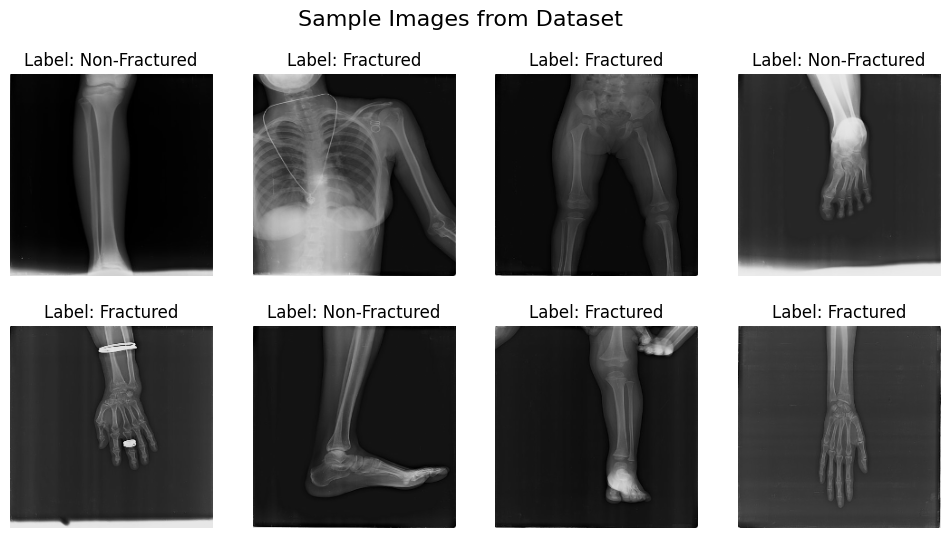

In [ ]:
# Create DataLoaders with shuffle disabled for full reproducibility
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Function to display images (remains unchanged)
def show_sample_images(loader):
    batch = next(iter(loader))  # Get one batch
    images, labels = batch

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle("Sample Images from Dataset", fontsize=16)

    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy
        img = (img * 0.5) + 0.5  # Denormalize
        ax.imshow(img)
        ax.set_title(f"Label: {'Fractured' if labels[i].item() == 1 else 'Non-Fractured'}")
        ax.axis("off")

    plt.show()

# Display sample images
show_sample_images(train_loader)

# Initializing Pretrained Models

We define a function to load and modify popular pretrained models for binary classification. The models are adjusted to have two output classes and are moved to the appropriate device (CPU/GPU). This ensures flexibility in experimenting with different architectures.

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch

# Define the device (fix for the NameError)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get different models
def get_model(name, pretrained=True):
    if name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(512, 2)  # Adjust output layer for binary classification
    elif name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(2048, 2)
    elif name == "efficientnet":
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    elif name == "densenet":
        model = models.densenet121(pretrained=pretrained)
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    else:
        raise ValueError("Invalid model name!")

    return model.to(device)  # Move model to device

# List of models we will test
model_names = ["resnet18", "resnet50", "efficientnet", "densenet"]
models_dict = {name: get_model(name) for name in model_names}

# Print model summaries
for name, model in models_dict.items():
    print(f"\n{name.upper()} Model Summary:\n", model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weig


RESNET18 Model Summary:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

In [ ]:
import torch.optim as optim

# Define training hyperparameters
learning_rates = [0.001, 0.0001]
criterion = nn.CrossEntropyLoss()  # Since it's a binary classification problem

# Create a dictionary of optimizers for each model at each learning rate
optimizers_dict = {}

for name, model in models_dict.items():
    for lr in learning_rates:
        optimizers_dict[(name, lr)] = optim.Adam(model.parameters(), lr=lr)

# Print confirmation
print(f"Optimizers set up for {len(optimizers_dict)} model-learning rate combinations.")

Optimizers set up for 8 model-learning rate combinations.


# Training the Models with Progress Tracking

We train multiple models using different learning rates while tracking progress with tqdm. The function logs training loss, accuracy, and F1-score per epoch. Checkpoints are saved every 10 epochs to prevent loss of progress, ensuring model recovery if needed.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# Training function with tqdm
def train_model(model, optimizer, train_loader, test_loader, num_epochs, model_name, lr):
    model.to(device)
    best_f1 = 0  # Track best F1-score
    history = []  # Store training history

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update tqdm description with live loss value
            progress_bar.set_postfix(loss=loss.item())

        # Compute training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average="weighted")

        # Store training history
        history.append([epoch, train_loss, train_acc, train_f1])

        # Print progress after each epoch
        print(f"Epoch {epoch}/{num_epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

        # Save checkpoint every 10 epochs
        if epoch % 10 == 0 or epoch == num_epochs:
            checkpoint_path = os.path.join(save_dir, f"{model_name}_lr{lr}_epoch{epoch}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")

    return history

# Re-run training with tqdm
train_histories = {}

for name, model in models_dict.items():
    for lr in learning_rates:
        print(f"\nTraining {name.upper()} with LR={lr}...")
        optimizer = optimizers_dict[(name, lr)]
        epochs = 15 if lr == 0.001 else 25  # Assign epochs based on learning rate

        history = train_model(model, optimizer, train_loader, test_loader, epochs, name, lr)
        train_histories[(name, lr)] = history


Training RESNET18 with LR=0.001...


Epoch 1/15: 100%|██████████| 144/144 [03:38<00:00,  1.52s/it, loss=1.12]


Epoch 1/15 | Loss: 0.6869 | Acc: 0.6068 | F1: 0.6068


Epoch 2/15: 100%|██████████| 144/144 [00:16<00:00,  8.68it/s, loss=1.04]


Epoch 2/15 | Loss: 0.6114 | Acc: 0.6626 | F1: 0.6626


Epoch 3/15: 100%|██████████| 144/144 [00:16<00:00,  8.55it/s, loss=0.666]


Epoch 3/15 | Loss: 0.6080 | Acc: 0.6844 | F1: 0.6842


Epoch 4/15: 100%|██████████| 144/144 [00:17<00:00,  8.31it/s, loss=0.363]


Epoch 4/15 | Loss: 0.5977 | Acc: 0.6870 | F1: 0.6859


Epoch 5/15: 100%|██████████| 144/144 [00:17<00:00,  8.13it/s, loss=0.266]


Epoch 5/15 | Loss: 0.5646 | Acc: 0.7114 | F1: 0.7114


Epoch 6/15: 100%|██████████| 144/144 [00:16<00:00,  8.58it/s, loss=0.478]


Epoch 6/15 | Loss: 0.5309 | Acc: 0.7419 | F1: 0.7418


Epoch 7/15: 100%|██████████| 144/144 [00:16<00:00,  8.54it/s, loss=1]


Epoch 7/15 | Loss: 0.5099 | Acc: 0.7533 | F1: 0.7532


Epoch 8/15: 100%|██████████| 144/144 [00:17<00:00,  8.30it/s, loss=1.03]


Epoch 8/15 | Loss: 0.5314 | Acc: 0.7472 | F1: 0.7471


Epoch 9/15: 100%|██████████| 144/144 [00:17<00:00,  8.18it/s, loss=0.187]


Epoch 9/15 | Loss: 0.4539 | Acc: 0.7960 | F1: 0.7960


Epoch 10/15: 100%|██████████| 144/144 [00:17<00:00,  8.43it/s, loss=1.02]


Epoch 10/15 | Loss: 0.4773 | Acc: 0.7925 | F1: 0.7925
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet18_lr0.001_epoch10.pth


Epoch 11/15: 100%|██████████| 144/144 [00:16<00:00,  8.53it/s, loss=0.173]


Epoch 11/15 | Loss: 0.4436 | Acc: 0.7960 | F1: 0.7960


Epoch 12/15: 100%|██████████| 144/144 [00:17<00:00,  8.03it/s, loss=0.633]


Epoch 12/15 | Loss: 0.4400 | Acc: 0.8143 | F1: 0.8143


Epoch 13/15: 100%|██████████| 144/144 [00:16<00:00,  8.53it/s, loss=0.14]


Epoch 13/15 | Loss: 0.4197 | Acc: 0.8099 | F1: 0.8099


Epoch 14/15: 100%|██████████| 144/144 [00:17<00:00,  8.36it/s, loss=0.489]


Epoch 14/15 | Loss: 0.3917 | Acc: 0.8387 | F1: 0.8387


Epoch 15/15: 100%|██████████| 144/144 [00:16<00:00,  8.71it/s, loss=0.489]


Epoch 15/15 | Loss: 0.3471 | Acc: 0.8500 | F1: 0.8500
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet18_lr0.001_epoch15.pth

Training RESNET18 with LR=0.0001...


Epoch 1/25: 100%|██████████| 144/144 [00:18<00:00,  7.74it/s, loss=0.105]


Epoch 1/25 | Loss: 0.2513 | Acc: 0.9015 | F1: 0.9015


Epoch 2/25: 100%|██████████| 144/144 [00:17<00:00,  8.45it/s, loss=0.0411]


Epoch 2/25 | Loss: 0.1607 | Acc: 0.9398 | F1: 0.9398


Epoch 3/25: 100%|██████████| 144/144 [00:16<00:00,  8.67it/s, loss=0.101]


Epoch 3/25 | Loss: 0.1250 | Acc: 0.9538 | F1: 0.9538


Epoch 4/25: 100%|██████████| 144/144 [00:16<00:00,  8.52it/s, loss=0.0329]


Epoch 4/25 | Loss: 0.0845 | Acc: 0.9712 | F1: 0.9712


Epoch 5/25: 100%|██████████| 144/144 [00:18<00:00,  8.00it/s, loss=0.944]


Epoch 5/25 | Loss: 0.0897 | Acc: 0.9730 | F1: 0.9730


Epoch 6/25: 100%|██████████| 144/144 [00:16<00:00,  8.55it/s, loss=0.00507]


Epoch 6/25 | Loss: 0.0699 | Acc: 0.9773 | F1: 0.9773


Epoch 7/25: 100%|██████████| 144/144 [00:16<00:00,  8.69it/s, loss=0.000659]


Epoch 7/25 | Loss: 0.0378 | Acc: 0.9904 | F1: 0.9904


Epoch 8/25: 100%|██████████| 144/144 [00:17<00:00,  8.46it/s, loss=0.00159]


Epoch 8/25 | Loss: 0.0660 | Acc: 0.9747 | F1: 0.9747


Epoch 9/25: 100%|██████████| 144/144 [00:17<00:00,  8.04it/s, loss=0.00197]


Epoch 9/25 | Loss: 0.0443 | Acc: 0.9843 | F1: 0.9843


Epoch 10/25: 100%|██████████| 144/144 [00:16<00:00,  8.66it/s, loss=1.02]


Epoch 10/25 | Loss: 0.0640 | Acc: 0.9834 | F1: 0.9834
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet18_lr0.0001_epoch10.pth


Epoch 11/25: 100%|██████████| 144/144 [00:16<00:00,  8.52it/s, loss=0.00616]


Epoch 11/25 | Loss: 0.0411 | Acc: 0.9887 | F1: 0.9887


Epoch 12/25: 100%|██████████| 144/144 [00:17<00:00,  8.46it/s, loss=0.00705]


Epoch 12/25 | Loss: 0.0316 | Acc: 0.9913 | F1: 0.9913


Epoch 13/25: 100%|██████████| 144/144 [00:18<00:00,  7.86it/s, loss=0.00172]


Epoch 13/25 | Loss: 0.0359 | Acc: 0.9904 | F1: 0.9904


Epoch 14/25: 100%|██████████| 144/144 [00:16<00:00,  8.54it/s, loss=0.473]


Epoch 14/25 | Loss: 0.0273 | Acc: 0.9948 | F1: 0.9948


Epoch 15/25: 100%|██████████| 144/144 [00:16<00:00,  8.60it/s, loss=0.00116]


Epoch 15/25 | Loss: 0.0308 | Acc: 0.9895 | F1: 0.9895


Epoch 16/25: 100%|██████████| 144/144 [00:17<00:00,  8.44it/s, loss=0.000651]


Epoch 16/25 | Loss: 0.0416 | Acc: 0.9869 | F1: 0.9869


Epoch 17/25: 100%|██████████| 144/144 [00:17<00:00,  8.15it/s, loss=0.00275]


Epoch 17/25 | Loss: 0.0296 | Acc: 0.9913 | F1: 0.9913


Epoch 18/25: 100%|██████████| 144/144 [00:16<00:00,  8.55it/s, loss=0.0203]


Epoch 18/25 | Loss: 0.0171 | Acc: 0.9948 | F1: 0.9948


Epoch 19/25: 100%|██████████| 144/144 [00:16<00:00,  8.79it/s, loss=0.00358]


Epoch 19/25 | Loss: 0.0280 | Acc: 0.9922 | F1: 0.9922


Epoch 20/25: 100%|██████████| 144/144 [00:16<00:00,  8.61it/s, loss=0.000504]


Epoch 20/25 | Loss: 0.0118 | Acc: 0.9965 | F1: 0.9965
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet18_lr0.0001_epoch20.pth


Epoch 21/25: 100%|██████████| 144/144 [00:18<00:00,  7.92it/s, loss=0.515]


Epoch 21/25 | Loss: 0.0121 | Acc: 0.9974 | F1: 0.9974


Epoch 22/25: 100%|██████████| 144/144 [00:17<00:00,  8.44it/s, loss=0.000309]


Epoch 22/25 | Loss: 0.0344 | Acc: 0.9895 | F1: 0.9895


Epoch 23/25: 100%|██████████| 144/144 [00:16<00:00,  8.63it/s, loss=0.69]


Epoch 23/25 | Loss: 0.0337 | Acc: 0.9895 | F1: 0.9895


Epoch 24/25: 100%|██████████| 144/144 [00:16<00:00,  8.51it/s, loss=2.71]


Epoch 24/25 | Loss: 0.0634 | Acc: 0.9861 | F1: 0.9861


Epoch 25/25: 100%|██████████| 144/144 [00:18<00:00,  7.91it/s, loss=0.021]


Epoch 25/25 | Loss: 0.0203 | Acc: 0.9948 | F1: 0.9948
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet18_lr0.0001_epoch25.pth

Training RESNET50 with LR=0.001...


Epoch 1/15: 100%|██████████| 144/144 [00:19<00:00,  7.28it/s, loss=0.574]


Epoch 1/15 | Loss: 0.7638 | Acc: 0.5510 | F1: 0.5507


Epoch 2/15: 100%|██████████| 144/144 [00:21<00:00,  6.83it/s, loss=0.543]


Epoch 2/15 | Loss: 0.7095 | Acc: 0.5405 | F1: 0.5351


Epoch 3/15: 100%|██████████| 144/144 [00:19<00:00,  7.45it/s, loss=0.752]


Epoch 3/15 | Loss: 0.6978 | Acc: 0.5527 | F1: 0.5521


Epoch 4/15: 100%|██████████| 144/144 [00:20<00:00,  7.10it/s, loss=0.465]


Epoch 4/15 | Loss: 0.6683 | Acc: 0.5981 | F1: 0.5977


Epoch 5/15: 100%|██████████| 144/144 [00:19<00:00,  7.40it/s, loss=0.887]


Epoch 5/15 | Loss: 0.6443 | Acc: 0.6330 | F1: 0.6328


Epoch 6/15: 100%|██████████| 144/144 [00:19<00:00,  7.24it/s, loss=0.619]


Epoch 6/15 | Loss: 0.6133 | Acc: 0.6591 | F1: 0.6586


Epoch 7/15: 100%|██████████| 144/144 [00:20<00:00,  7.16it/s, loss=0.649]


Epoch 7/15 | Loss: 0.6187 | Acc: 0.6626 | F1: 0.6617


Epoch 8/15: 100%|██████████| 144/144 [00:19<00:00,  7.24it/s, loss=1]


Epoch 8/15 | Loss: 0.6093 | Acc: 0.6704 | F1: 0.6691


Epoch 9/15: 100%|██████████| 144/144 [00:20<00:00,  6.96it/s, loss=1.1]


Epoch 9/15 | Loss: 0.6197 | Acc: 0.6687 | F1: 0.6680


Epoch 10/15: 100%|██████████| 144/144 [00:19<00:00,  7.40it/s, loss=0.582]


Epoch 10/15 | Loss: 0.6192 | Acc: 0.6739 | F1: 0.6732
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet50_lr0.001_epoch10.pth


Epoch 11/15: 100%|██████████| 144/144 [00:21<00:00,  6.77it/s, loss=0.798]


Epoch 11/15 | Loss: 0.5914 | Acc: 0.6905 | F1: 0.6901


Epoch 12/15: 100%|██████████| 144/144 [00:19<00:00,  7.31it/s, loss=0.856]


Epoch 12/15 | Loss: 0.6122 | Acc: 0.6765 | F1: 0.6762


Epoch 13/15: 100%|██████████| 144/144 [00:20<00:00,  6.93it/s, loss=0.439]


Epoch 13/15 | Loss: 0.5871 | Acc: 0.6992 | F1: 0.6989


Epoch 14/15: 100%|██████████| 144/144 [00:19<00:00,  7.32it/s, loss=0.921]


Epoch 14/15 | Loss: 0.6233 | Acc: 0.6556 | F1: 0.6552


Epoch 15/15: 100%|██████████| 144/144 [00:20<00:00,  6.95it/s, loss=0.593]


Epoch 15/15 | Loss: 0.6208 | Acc: 0.6696 | F1: 0.6691
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet50_lr0.001_epoch15.pth

Training RESNET50 with LR=0.0001...


Epoch 1/25: 100%|██████████| 144/144 [00:20<00:00,  7.06it/s, loss=1.12]


Epoch 1/25 | Loss: 0.5755 | Acc: 0.7158 | F1: 0.7146


Epoch 2/25: 100%|██████████| 144/144 [00:20<00:00,  6.87it/s, loss=0.675]


Epoch 2/25 | Loss: 0.5472 | Acc: 0.7123 | F1: 0.7116


Epoch 3/25: 100%|██████████| 144/144 [00:19<00:00,  7.28it/s, loss=0.727]


Epoch 3/25 | Loss: 0.5467 | Acc: 0.7315 | F1: 0.7307


Epoch 4/25: 100%|██████████| 144/144 [00:20<00:00,  6.88it/s, loss=0.27]


Epoch 4/25 | Loss: 0.5213 | Acc: 0.7568 | F1: 0.7567


Epoch 5/25: 100%|██████████| 144/144 [00:19<00:00,  7.33it/s, loss=0.51]


Epoch 5/25 | Loss: 0.5168 | Acc: 0.7402 | F1: 0.7402


Epoch 6/25: 100%|██████████| 144/144 [00:21<00:00,  6.73it/s, loss=0.404]


Epoch 6/25 | Loss: 0.4818 | Acc: 0.7690 | F1: 0.7689


Epoch 7/25: 100%|██████████| 144/144 [00:19<00:00,  7.34it/s, loss=0.206]


Epoch 7/25 | Loss: 0.4688 | Acc: 0.7881 | F1: 0.7881


Epoch 8/25: 100%|██████████| 144/144 [00:20<00:00,  6.89it/s, loss=0.297]


Epoch 8/25 | Loss: 0.4425 | Acc: 0.7925 | F1: 0.7924


Epoch 9/25: 100%|██████████| 144/144 [00:19<00:00,  7.24it/s, loss=0.285]


Epoch 9/25 | Loss: 0.4196 | Acc: 0.8038 | F1: 0.8038


Epoch 10/25: 100%|██████████| 144/144 [00:21<00:00,  6.65it/s, loss=1.02]


Epoch 10/25 | Loss: 0.4194 | Acc: 0.8047 | F1: 0.8047
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet50_lr0.0001_epoch10.pth


Epoch 11/25: 100%|██████████| 144/144 [00:20<00:00,  6.98it/s, loss=0.701]


Epoch 11/25 | Loss: 0.3466 | Acc: 0.8483 | F1: 0.8483


Epoch 12/25: 100%|██████████| 144/144 [00:21<00:00,  6.80it/s, loss=0.136]


Epoch 12/25 | Loss: 0.3153 | Acc: 0.8605 | F1: 0.8605


Epoch 13/25: 100%|██████████| 144/144 [00:20<00:00,  7.15it/s, loss=0.121]


Epoch 13/25 | Loss: 0.2679 | Acc: 0.8928 | F1: 0.8928


Epoch 14/25: 100%|██████████| 144/144 [00:21<00:00,  6.79it/s, loss=0.627]


Epoch 14/25 | Loss: 0.2337 | Acc: 0.9154 | F1: 0.9154


Epoch 15/25: 100%|██████████| 144/144 [00:19<00:00,  7.23it/s, loss=0.516]


Epoch 15/25 | Loss: 0.2264 | Acc: 0.9102 | F1: 0.9102


Epoch 16/25: 100%|██████████| 144/144 [00:20<00:00,  6.87it/s, loss=1.22]


Epoch 16/25 | Loss: 0.1887 | Acc: 0.9425 | F1: 0.9425


Epoch 17/25: 100%|██████████| 144/144 [00:19<00:00,  7.27it/s, loss=0.72]


Epoch 17/25 | Loss: 0.1379 | Acc: 0.9503 | F1: 0.9503


Epoch 18/25: 100%|██████████| 144/144 [00:21<00:00,  6.75it/s, loss=0.461]


Epoch 18/25 | Loss: 0.1338 | Acc: 0.9468 | F1: 0.9468


Epoch 19/25: 100%|██████████| 144/144 [00:20<00:00,  7.07it/s, loss=0.0422]


Epoch 19/25 | Loss: 0.1256 | Acc: 0.9538 | F1: 0.9538


Epoch 20/25: 100%|██████████| 144/144 [00:21<00:00,  6.74it/s, loss=0.48]


Epoch 20/25 | Loss: 0.1078 | Acc: 0.9677 | F1: 0.9677
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet50_lr0.0001_epoch20.pth


Epoch 21/25: 100%|██████████| 144/144 [00:20<00:00,  7.01it/s, loss=0.106]


Epoch 21/25 | Loss: 0.1136 | Acc: 0.9529 | F1: 0.9529


Epoch 22/25: 100%|██████████| 144/144 [00:21<00:00,  6.78it/s, loss=1.39]


Epoch 22/25 | Loss: 0.0977 | Acc: 0.9677 | F1: 0.9677


Epoch 23/25: 100%|██████████| 144/144 [00:19<00:00,  7.22it/s, loss=0.017]


Epoch 23/25 | Loss: 0.0867 | Acc: 0.9730 | F1: 0.9730


Epoch 24/25: 100%|██████████| 144/144 [00:21<00:00,  6.73it/s, loss=0.00203]


Epoch 24/25 | Loss: 0.0812 | Acc: 0.9730 | F1: 0.9730


Epoch 25/25: 100%|██████████| 144/144 [00:20<00:00,  7.16it/s, loss=0.0854]


Epoch 25/25 | Loss: 0.0504 | Acc: 0.9808 | F1: 0.9808
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/resnet50_lr0.0001_epoch25.pth

Training EFFICIENTNET with LR=0.001...


Epoch 1/15: 100%|██████████| 144/144 [00:20<00:00,  6.96it/s, loss=0.595]


Epoch 1/15 | Loss: 0.6273 | Acc: 0.6783 | F1: 0.6782


Epoch 2/15: 100%|██████████| 144/144 [00:19<00:00,  7.26it/s, loss=0.244]


Epoch 2/15 | Loss: 0.5431 | Acc: 0.7341 | F1: 0.7340


Epoch 3/15: 100%|██████████| 144/144 [00:20<00:00,  7.12it/s, loss=0.251]


Epoch 3/15 | Loss: 0.5067 | Acc: 0.7751 | F1: 0.7750


Epoch 4/15: 100%|██████████| 144/144 [00:19<00:00,  7.37it/s, loss=0.31]


Epoch 4/15 | Loss: 0.4543 | Acc: 0.7960 | F1: 0.7960


Epoch 5/15: 100%|██████████| 144/144 [00:20<00:00,  6.97it/s, loss=0.492]


Epoch 5/15 | Loss: 0.4169 | Acc: 0.8152 | F1: 0.8152


Epoch 6/15: 100%|██████████| 144/144 [00:19<00:00,  7.35it/s, loss=0.181]


Epoch 6/15 | Loss: 0.3712 | Acc: 0.8466 | F1: 0.8465


Epoch 7/15: 100%|██████████| 144/144 [00:20<00:00,  6.97it/s, loss=1.01]


Epoch 7/15 | Loss: 0.3309 | Acc: 0.8666 | F1: 0.8666


Epoch 8/15: 100%|██████████| 144/144 [00:19<00:00,  7.38it/s, loss=1.4]


Epoch 8/15 | Loss: 0.2731 | Acc: 0.8884 | F1: 0.8884


Epoch 9/15: 100%|██████████| 144/144 [00:20<00:00,  6.92it/s, loss=0.325]


Epoch 9/15 | Loss: 0.2320 | Acc: 0.9180 | F1: 0.9180


Epoch 10/15: 100%|██████████| 144/144 [00:19<00:00,  7.54it/s, loss=0.901]


Epoch 10/15 | Loss: 0.2173 | Acc: 0.9128 | F1: 0.9128
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_lr0.001_epoch10.pth


Epoch 11/15: 100%|██████████| 144/144 [00:20<00:00,  6.94it/s, loss=0.102]


Epoch 11/15 | Loss: 0.1677 | Acc: 0.9337 | F1: 0.9337


Epoch 12/15: 100%|██████████| 144/144 [00:19<00:00,  7.41it/s, loss=0.289]


Epoch 12/15 | Loss: 0.1441 | Acc: 0.9486 | F1: 0.9486


Epoch 13/15: 100%|██████████| 144/144 [00:20<00:00,  6.98it/s, loss=0.343]


Epoch 13/15 | Loss: 0.1310 | Acc: 0.9512 | F1: 0.9512


Epoch 14/15: 100%|██████████| 144/144 [00:19<00:00,  7.46it/s, loss=0.00183]


Epoch 14/15 | Loss: 0.0866 | Acc: 0.9738 | F1: 0.9738


Epoch 15/15: 100%|██████████| 144/144 [00:20<00:00,  7.11it/s, loss=0.0371]


Epoch 15/15 | Loss: 0.1143 | Acc: 0.9677 | F1: 0.9677
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_lr0.001_epoch15.pth

Training EFFICIENTNET with LR=0.0001...


Epoch 1/25: 100%|██████████| 144/144 [00:19<00:00,  7.35it/s, loss=0.0068]


Epoch 1/25 | Loss: 0.0489 | Acc: 0.9861 | F1: 0.9861


Epoch 2/25: 100%|██████████| 144/144 [00:20<00:00,  7.16it/s, loss=0.301]


Epoch 2/25 | Loss: 0.0259 | Acc: 0.9930 | F1: 0.9930


Epoch 3/25: 100%|██████████| 144/144 [00:19<00:00,  7.26it/s, loss=0.00061]


Epoch 3/25 | Loss: 0.0128 | Acc: 0.9965 | F1: 0.9965


Epoch 4/25: 100%|██████████| 144/144 [00:19<00:00,  7.54it/s, loss=0.0139]


Epoch 4/25 | Loss: 0.0136 | Acc: 0.9948 | F1: 0.9948


Epoch 5/25: 100%|██████████| 144/144 [00:20<00:00,  7.01it/s, loss=0.00331]


Epoch 5/25 | Loss: 0.0080 | Acc: 0.9974 | F1: 0.9974


Epoch 6/25: 100%|██████████| 144/144 [00:19<00:00,  7.56it/s, loss=7.94e-5]


Epoch 6/25 | Loss: 0.0074 | Acc: 0.9974 | F1: 0.9974


Epoch 7/25: 100%|██████████| 144/144 [00:20<00:00,  6.97it/s, loss=0.000652]


Epoch 7/25 | Loss: 0.0119 | Acc: 0.9956 | F1: 0.9956


Epoch 8/25: 100%|██████████| 144/144 [00:19<00:00,  7.44it/s, loss=9.06e-5]


Epoch 8/25 | Loss: 0.0038 | Acc: 0.9983 | F1: 0.9983


Epoch 9/25: 100%|██████████| 144/144 [00:20<00:00,  6.98it/s, loss=0.000449]


Epoch 9/25 | Loss: 0.0048 | Acc: 0.9983 | F1: 0.9983


Epoch 10/25: 100%|██████████| 144/144 [00:19<00:00,  7.49it/s, loss=0.0112]


Epoch 10/25 | Loss: 0.0073 | Acc: 0.9974 | F1: 0.9974
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_lr0.0001_epoch10.pth


Epoch 11/25: 100%|██████████| 144/144 [00:20<00:00,  6.87it/s, loss=8.16e-5]


Epoch 11/25 | Loss: 0.0047 | Acc: 0.9983 | F1: 0.9983


Epoch 12/25: 100%|██████████| 144/144 [00:19<00:00,  7.38it/s, loss=4.57e-5]


Epoch 12/25 | Loss: 0.0055 | Acc: 0.9991 | F1: 0.9991


Epoch 13/25: 100%|██████████| 144/144 [00:20<00:00,  7.09it/s, loss=0.0136]


Epoch 13/25 | Loss: 0.0033 | Acc: 0.9991 | F1: 0.9991


Epoch 14/25: 100%|██████████| 144/144 [00:19<00:00,  7.32it/s, loss=0.000117]


Epoch 14/25 | Loss: 0.0050 | Acc: 0.9974 | F1: 0.9974


Epoch 15/25: 100%|██████████| 144/144 [00:20<00:00,  7.16it/s, loss=0.00637]


Epoch 15/25 | Loss: 0.0018 | Acc: 0.9991 | F1: 0.9991


Epoch 16/25: 100%|██████████| 144/144 [00:19<00:00,  7.29it/s, loss=6.64e-5]


Epoch 16/25 | Loss: 0.0033 | Acc: 0.9974 | F1: 0.9974


Epoch 17/25: 100%|██████████| 144/144 [00:19<00:00,  7.36it/s, loss=0.00349]


Epoch 17/25 | Loss: 0.0020 | Acc: 0.9991 | F1: 0.9991


Epoch 18/25: 100%|██████████| 144/144 [00:20<00:00,  7.18it/s, loss=8.36e-5]


Epoch 18/25 | Loss: 0.0095 | Acc: 0.9974 | F1: 0.9974


Epoch 19/25: 100%|██████████| 144/144 [00:19<00:00,  7.56it/s, loss=8.22e-5]


Epoch 19/25 | Loss: 0.0042 | Acc: 0.9983 | F1: 0.9983


Epoch 20/25: 100%|██████████| 144/144 [00:20<00:00,  7.03it/s, loss=0.022]


Epoch 20/25 | Loss: 0.0035 | Acc: 0.9983 | F1: 0.9983
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_lr0.0001_epoch20.pth


Epoch 21/25: 100%|██████████| 144/144 [00:19<00:00,  7.39it/s, loss=2.9e-6]


Epoch 21/25 | Loss: 0.0057 | Acc: 0.9974 | F1: 0.9974


Epoch 22/25: 100%|██████████| 144/144 [00:20<00:00,  6.92it/s, loss=0.000584]


Epoch 22/25 | Loss: 0.0064 | Acc: 0.9983 | F1: 0.9983


Epoch 23/25: 100%|██████████| 144/144 [00:19<00:00,  7.46it/s, loss=0.00165]


Epoch 23/25 | Loss: 0.0008 | Acc: 1.0000 | F1: 1.0000


Epoch 24/25: 100%|██████████| 144/144 [00:20<00:00,  7.01it/s, loss=1.83e-6]


Epoch 24/25 | Loss: 0.0023 | Acc: 0.9991 | F1: 0.9991


Epoch 25/25: 100%|██████████| 144/144 [00:19<00:00,  7.41it/s, loss=0.000102]


Epoch 25/25 | Loss: 0.0140 | Acc: 0.9956 | F1: 0.9956
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_lr0.0001_epoch25.pth

Training DENSENET with LR=0.001...


Epoch 1/15: 100%|██████████| 144/144 [00:25<00:00,  5.63it/s, loss=0.795]


Epoch 1/15 | Loss: 0.6509 | Acc: 0.6486 | F1: 0.6486


Epoch 2/15: 100%|██████████| 144/144 [00:25<00:00,  5.66it/s, loss=0.472]


Epoch 2/15 | Loss: 0.6193 | Acc: 0.6486 | F1: 0.6486


Epoch 3/15: 100%|██████████| 144/144 [00:25<00:00,  5.75it/s, loss=0.49]


Epoch 3/15 | Loss: 0.5813 | Acc: 0.7062 | F1: 0.7051


Epoch 4/15: 100%|██████████| 144/144 [00:25<00:00,  5.76it/s, loss=0.584]


Epoch 4/15 | Loss: 0.6050 | Acc: 0.6853 | F1: 0.6853


Epoch 5/15: 100%|██████████| 144/144 [00:24<00:00,  5.96it/s, loss=0.932]


Epoch 5/15 | Loss: 0.5844 | Acc: 0.7053 | F1: 0.7051


Epoch 6/15: 100%|██████████| 144/144 [00:24<00:00,  5.82it/s, loss=0.158]


Epoch 6/15 | Loss: 0.5414 | Acc: 0.7236 | F1: 0.7236


Epoch 7/15: 100%|██████████| 144/144 [00:25<00:00,  5.75it/s, loss=0.464]


Epoch 7/15 | Loss: 0.5373 | Acc: 0.7280 | F1: 0.7279


Epoch 8/15: 100%|██████████| 144/144 [00:25<00:00,  5.66it/s, loss=0.282]


Epoch 8/15 | Loss: 0.5222 | Acc: 0.7437 | F1: 0.7437


Epoch 9/15: 100%|██████████| 144/144 [00:25<00:00,  5.70it/s, loss=0.416]


Epoch 9/15 | Loss: 0.4994 | Acc: 0.7594 | F1: 0.7594


Epoch 10/15: 100%|██████████| 144/144 [00:25<00:00,  5.74it/s, loss=0.797]


Epoch 10/15 | Loss: 0.5279 | Acc: 0.7533 | F1: 0.7532
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/densenet_lr0.001_epoch10.pth


Epoch 11/15: 100%|██████████| 144/144 [00:24<00:00,  5.83it/s, loss=0.203]


Epoch 11/15 | Loss: 0.5101 | Acc: 0.7428 | F1: 0.7428


Epoch 12/15: 100%|██████████| 144/144 [00:24<00:00,  5.87it/s, loss=0.221]


Epoch 12/15 | Loss: 0.5003 | Acc: 0.7690 | F1: 0.7689


Epoch 13/15: 100%|██████████| 144/144 [00:24<00:00,  5.76it/s, loss=0.603]


Epoch 13/15 | Loss: 0.4773 | Acc: 0.7873 | F1: 0.7872


Epoch 14/15: 100%|██████████| 144/144 [00:25<00:00,  5.66it/s, loss=0.437]


Epoch 14/15 | Loss: 0.4551 | Acc: 0.7881 | F1: 0.7881


Epoch 15/15: 100%|██████████| 144/144 [00:25<00:00,  5.72it/s, loss=0.171]


Epoch 15/15 | Loss: 0.4690 | Acc: 0.7916 | F1: 0.7916
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/densenet_lr0.001_epoch15.pth

Training DENSENET with LR=0.0001...


Epoch 1/25: 100%|██████████| 144/144 [00:25<00:00,  5.74it/s, loss=0.979]


Epoch 1/25 | Loss: 0.4208 | Acc: 0.8152 | F1: 0.8152


Epoch 2/25: 100%|██████████| 144/144 [00:24<00:00,  5.82it/s, loss=1.07]


Epoch 2/25 | Loss: 0.3496 | Acc: 0.8579 | F1: 0.8579


Epoch 3/25: 100%|██████████| 144/144 [00:23<00:00,  6.02it/s, loss=0.0735]


Epoch 3/25 | Loss: 0.3080 | Acc: 0.8727 | F1: 0.8727


Epoch 4/25: 100%|██████████| 144/144 [00:24<00:00,  5.83it/s, loss=0.651]


Epoch 4/25 | Loss: 0.2562 | Acc: 0.9058 | F1: 0.9058


Epoch 5/25: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s, loss=0.0234]


Epoch 5/25 | Loss: 0.2656 | Acc: 0.8901 | F1: 0.8901


Epoch 6/25: 100%|██████████| 144/144 [00:24<00:00,  5.80it/s, loss=0.886]


Epoch 6/25 | Loss: 0.2032 | Acc: 0.9215 | F1: 0.9215


Epoch 7/25: 100%|██████████| 144/144 [00:25<00:00,  5.75it/s, loss=1.05]


Epoch 7/25 | Loss: 0.2310 | Acc: 0.9128 | F1: 0.9128


Epoch 8/25: 100%|██████████| 144/144 [00:23<00:00,  6.03it/s, loss=1.12]


Epoch 8/25 | Loss: 0.1826 | Acc: 0.9320 | F1: 0.9320


Epoch 9/25: 100%|██████████| 144/144 [00:24<00:00,  5.86it/s, loss=0.0111]


Epoch 9/25 | Loss: 0.1677 | Acc: 0.9372 | F1: 0.9372


Epoch 10/25: 100%|██████████| 144/144 [00:24<00:00,  5.83it/s, loss=0.0175]


Epoch 10/25 | Loss: 0.1533 | Acc: 0.9451 | F1: 0.9451
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/densenet_lr0.0001_epoch10.pth


Epoch 11/25: 100%|██████████| 144/144 [00:24<00:00,  5.82it/s, loss=0.311]


Epoch 11/25 | Loss: 0.1640 | Acc: 0.9355 | F1: 0.9355


Epoch 12/25: 100%|██████████| 144/144 [00:25<00:00,  5.73it/s, loss=1.41]


Epoch 12/25 | Loss: 0.0865 | Acc: 0.9773 | F1: 0.9773


Epoch 13/25: 100%|██████████| 144/144 [00:24<00:00,  5.97it/s, loss=0.0111]


Epoch 13/25 | Loss: 0.1159 | Acc: 0.9660 | F1: 0.9660


Epoch 14/25: 100%|██████████| 144/144 [00:24<00:00,  5.94it/s, loss=0.00315]


Epoch 14/25 | Loss: 0.0856 | Acc: 0.9712 | F1: 0.9712


Epoch 15/25: 100%|██████████| 144/144 [00:25<00:00,  5.76it/s, loss=0.0733]


Epoch 15/25 | Loss: 0.1246 | Acc: 0.9564 | F1: 0.9564


Epoch 16/25: 100%|██████████| 144/144 [00:24<00:00,  5.80it/s, loss=0.444]


Epoch 16/25 | Loss: 0.0851 | Acc: 0.9730 | F1: 0.9730


Epoch 17/25: 100%|██████████| 144/144 [00:24<00:00,  5.78it/s, loss=0.0646]


Epoch 17/25 | Loss: 0.0390 | Acc: 0.9887 | F1: 0.9887


Epoch 18/25: 100%|██████████| 144/144 [00:24<00:00,  5.80it/s, loss=1.2]


Epoch 18/25 | Loss: 0.0820 | Acc: 0.9756 | F1: 0.9756


Epoch 19/25: 100%|██████████| 144/144 [00:23<00:00,  6.08it/s, loss=0.00564]


Epoch 19/25 | Loss: 0.0757 | Acc: 0.9799 | F1: 0.9799


Epoch 20/25: 100%|██████████| 144/144 [00:25<00:00,  5.72it/s, loss=0.000577]


Epoch 20/25 | Loss: 0.0506 | Acc: 0.9826 | F1: 0.9826
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/densenet_lr0.0001_epoch20.pth


Epoch 21/25: 100%|██████████| 144/144 [00:24<00:00,  5.78it/s, loss=0.00077]


Epoch 21/25 | Loss: 0.0569 | Acc: 0.9834 | F1: 0.9834


Epoch 22/25: 100%|██████████| 144/144 [00:24<00:00,  5.77it/s, loss=0.288]


Epoch 22/25 | Loss: 0.0398 | Acc: 0.9939 | F1: 0.9939


Epoch 23/25: 100%|██████████| 144/144 [00:24<00:00,  5.77it/s, loss=0.00124]


Epoch 23/25 | Loss: 0.0255 | Acc: 0.9930 | F1: 0.9930


Epoch 24/25: 100%|██████████| 144/144 [00:23<00:00,  6.07it/s, loss=0.651]


Epoch 24/25 | Loss: 0.0591 | Acc: 0.9826 | F1: 0.9826


Epoch 25/25: 100%|██████████| 144/144 [00:24<00:00,  5.82it/s, loss=0.102]


Epoch 25/25 | Loss: 0.0404 | Acc: 0.9852 | F1: 0.9852
Checkpoint saved: /content/drive/MyDrive/FracAtlas/models/densenet_lr0.0001_epoch25.pth


In [ ]:
from PIL import Image                 # No need to rerun

# Define transformations for basic augmentation
basic_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Keep normalization
])

# Path to save precomputed transformations
transform_csv_path = "/content/drive/MyDrive/FracAtlas/splits/basic_transformations.csv"

# Set random seed for reproducibility
torch.manual_seed(SEED)

# Function to precompute transformations
def precompute_transformations(dataset, save_path):
    records = []

    for idx in range(len(dataset)):
        image_path = dataset.data.iloc[idx, 0]

        # Load image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        # Convert grayscale images to RGB
        if len(image.shape) == 2:  # Grayscale image
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Convert to PIL format (fix for TypeError)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Apply transformations
        torch.manual_seed(SEED + idx)  # Ensure reproducibility per image
        transformed_image = basic_transform(image)  # Apply transformations

        # Save transformation record
        records.append([image_path])

    # Save to CSV
    df_transforms = pd.DataFrame(records, columns=["image_path"])
    df_transforms.to_csv(save_path, index=False)
    print(f"✅ Basic transformations precomputed and saved to: {save_path}")

# Precompute transformations
precompute_transformations(train_dataset, transform_csv_path)

✅ Basic transformations precomputed and saved to: /content/drive/MyDrive/FracAtlas/splits/basic_transformations.csv


In [ ]:
import pandas as pd # Rerun this instead

# Load precomputed transformations from CSV
transform_csv_path = "/content/drive/MyDrive/FracAtlas/splits/basic_transformations.csv"

# Check if the transformation file exists
if not os.path.exists(transform_csv_path):
    print("Error: Transformation CSV not found! Make sure it was precomputed.")
else:
    print(f"✅ Precomputed transformations loaded from: {transform_csv_path}")


✅ Precomputed transformations loaded from: /content/drive/MyDrive/FracAtlas/splits/basic_transformations.csv


We introduce basic transformations such as random flipping, rotation, and color jitter to improve model generalization. Additionally, we fix image resizing issues by ensuring all images are resized before transformation. A custom collate_fn is used to prevent batch-related errors. Finally, we reinitialize DataLoaders with these improvements for stable training.

In [ ]:
from torchvision import transforms            # Rerun this

# Define transformations for basic augmentation
basic_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Keep normalization
])

print("✅ Basic transformations reloaded successfully.")

import torch

# Fix: Custom collate function to prevent batch issues
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)  # Stack images into a batch
    labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor
    return images, labels

print("✅ collate_fn function reloaded successfully.")


# Fix: Ensure all images are resized correctly before transformations
class FractureDatasetWithPrecomputedTransforms(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]

        # Load image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        # Convert grayscale images to RGB
        if len(image.shape) == 2:  # Grayscale image
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Convert to PIL format
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # ✅ Ensure resizing happens BEFORE any transformation
        image = image.resize((224, 224))

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Ensure all images are (3, 224, 224) after transformation
        if image.shape != (3, 224, 224):
            print(f"⚠️ Image size mismatch detected: {image_path} has shape {image.shape}")

        # Assign label based on file path
        label = 1 if "Fractured" in image_path else 0

        return image, torch.tensor(label, dtype=torch.long)

# Reinitialize DataLoaders with the fixed dataset
train_dataset_transformed = FractureDatasetWithPrecomputedTransforms(train_csv_path, transform=basic_transform)
test_dataset_transformed = FractureDatasetWithPrecomputedTransforms(test_csv_path, transform=transform)

train_loader_transformed = DataLoader(
    train_dataset_transformed,
    batch_size=8,
    shuffle=True,
    num_workers=0,  # Reduce workers to avoid multiprocessing issues
    collate_fn=collate_fn
)

test_loader_transformed = DataLoader(
    test_dataset_transformed,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print("✅ Image size issue fixed. Ready to retrain.")

✅ Basic transformations reloaded successfully.
✅ collate_fn function reloaded successfully.
✅ Image size issue fixed. Ready to retrain.


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

# Retraining Promising Models with Augmented Data

We enhance the training process by incorporating torchmetrics for precise F1-score tracking. The updated function now includes a validation phase and saves the model only after the final epoch to optimize storage. Training progress is monitored with tqdm, ensuring efficient tracking of loss, accuracy, and F1-score throughout the process.

In [ ]:
import torchmetrics

# Define F1 metric for binary classification
f1_metric = torchmetrics.classification.BinaryF1Score().to(device)

# Updated train function with tqdm, F1-score, and saving only after the final epoch
def train_model(model, optimizer, train_loader, test_loader, num_epochs, model_name, learning_rate):
    history = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        f1_metric.reset()  # Reset F1-score for the epoch

        # Add tqdm progress bar for training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update F1-score
            f1_metric.update(predicted, labels)

            # Update tqdm description
            progress_bar.set_postfix(loss=loss.item(), acc=correct / total)

        train_loss = total_loss / total
        train_acc = correct / total
        train_f1 = f1_metric.compute().item()  # Compute F1-score for the epoch

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        f1_metric.reset()

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.functional.cross_entropy(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Update F1-score
                f1_metric.update(predicted, labels)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_f1 = f1_metric.compute().item()  # Compute F1-score for validation

        print(f"Epoch {epoch}/{num_epochs} | Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

        # Save training history
        history.append((epoch, val_loss, val_acc, val_f1))

        # ✅ Save the model ONLY after the final epoch
        if epoch == num_epochs:
            checkpoint_path = f"/content/drive/MyDrive/FracAtlas/models/{model_name}_lr{learning_rate}_final.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Final model saved: {checkpoint_path}")

    return history

# Train models with tqdm progress bars
train_histories_transformed = {}

for name, model in selected_models.items():
    print(f"\n🔄 Retraining {name.upper()} with basic transformations...")
    optimizer = optimizers_transformed[name]

    # ✅ Call the train_model function
    history = train_model(model, optimizer, train_loader_transformed, test_loader_transformed, 25, name, 0.0001)

    # Store history
    train_histories_transformed[name] = history

print("✅ Training with basic transformations complete!")


🔄 Retraining EFFICIENTNET with basic transformations...


Epoch 1/25 | Loss: 0.7811 | Acc: 0.7979 | F1: 0.7698


Epoch 2/25 | Loss: 0.6958 | Acc: 0.8014 | F1: 0.7897


Epoch 3/25 | Loss: 0.7951 | Acc: 0.8014 | F1: 0.7799


Epoch 4/25 | Loss: 0.6580 | Acc: 0.8049 | F1: 0.7971


Epoch 5/25 | Loss: 0.7473 | Acc: 0.8153 | F1: 0.7969


Epoch 6/25 | Loss: 0.6994 | Acc: 0.8153 | F1: 0.8030


Epoch 7/25 | Loss: 0.7679 | Acc: 0.7979 | F1: 0.7852


Epoch 8/25 | Loss: 0.7296 | Acc: 0.8118 | F1: 0.7923


Epoch 9/25 | Loss: 0.7704 | Acc: 0.8118 | F1: 0.7939


Epoch 10/25 | Loss: 0.8001 | Acc: 0.8049 | F1: 0.7926


Epoch 11/25 | Loss: 0.8945 | Acc: 0.8153 | F1: 0.7938


Epoch 12/25 | Loss: 0.8734 | Acc: 0.7979 | F1: 0.7803


Epoch 13/25 | Loss: 0.8774 | Acc: 0.8049 | F1: 0.7829


Epoch 14/25 | Loss: 0.8414 | Acc: 0.8118 | F1: 0.7955


Epoch 15/25 | Loss: 0.9645 | Acc: 0.7909 | F1: 0.7674


Epoch 16/25 | Loss: 0.8864 | Acc: 0.7909 | F1: 0.7810


Epoch 17/25 | Loss: 0.7881 | Acc: 0.8049 | F1: 0.7941


Epoch 18/25 | Loss: 0.8849 | Acc: 0.7944 | F1: 0.7807


Epoch 19/25 | Loss: 1.0834 | Acc: 0.7944 | F1: 0.7739


Epoch 20/25 | Loss: 0.9717 | Acc: 0.7700 | F1: 0.7692


Epoch 21/25 | Loss: 0.9539 | Acc: 0.7944 | F1: 0.7790


Epoch 22/25 | Loss: 1.1335 | Acc: 0.8014 | F1: 0.7747


Epoch 23/25 | Loss: 0.9616 | Acc: 0.7979 | F1: 0.7836


Epoch 24/25 | Loss: 0.8701 | Acc: 0.7944 | F1: 0.7885


Epoch 25/25 | Loss: 0.9645 | Acc: 0.7909 | F1: 0.7826
✅ Final model saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_lr0.0001_final.pth

🔄 Retraining RESNET18 with basic transformations...


Epoch 1/25 | Loss: 0.6561 | Acc: 0.7456 | F1: 0.7020


Epoch 2/25 | Loss: 0.6003 | Acc: 0.7596 | F1: 0.7356


Epoch 3/25 | Loss: 0.5710 | Acc: 0.7735 | F1: 0.7510


Epoch 4/25 | Loss: 0.5581 | Acc: 0.7805 | F1: 0.7623


Epoch 5/25 | Loss: 0.6625 | Acc: 0.7770 | F1: 0.7500


Epoch 6/25 | Loss: 0.5514 | Acc: 0.7735 | F1: 0.7636


Epoch 7/25 | Loss: 0.5834 | Acc: 0.7526 | F1: 0.7237


Epoch 8/25 | Loss: 0.5788 | Acc: 0.7735 | F1: 0.7471


Epoch 9/25 | Loss: 0.6510 | Acc: 0.7631 | F1: 0.7280


Epoch 10/25 | Loss: 0.6563 | Acc: 0.7526 | F1: 0.7029


Epoch 11/25 | Loss: 0.5644 | Acc: 0.7735 | F1: 0.7368


Epoch 12/25 | Loss: 0.5956 | Acc: 0.7840 | F1: 0.7687


Epoch 13/25 | Loss: 0.5956 | Acc: 0.7840 | F1: 0.7559


Epoch 14/25 | Loss: 0.5146 | Acc: 0.7596 | F1: 0.7596


Epoch 15/25 | Loss: 0.6347 | Acc: 0.7840 | F1: 0.7704


Epoch 16/25 | Loss: 0.5491 | Acc: 0.7700 | F1: 0.7537


Epoch 17/25 | Loss: 0.6957 | Acc: 0.7805 | F1: 0.7640


Epoch 18/25 | Loss: 0.7166 | Acc: 0.7596 | F1: 0.7273


Epoch 19/25 | Loss: 0.5719 | Acc: 0.7840 | F1: 0.7615


Epoch 20/25 | Loss: 0.5800 | Acc: 0.7840 | F1: 0.7669


Epoch 21/25 | Loss: 0.6610 | Acc: 0.7700 | F1: 0.7500


Epoch 22/25 | Loss: 0.7181 | Acc: 0.7666 | F1: 0.7352


Epoch 23/25 | Loss: 0.7510 | Acc: 0.7735 | F1: 0.7325


Epoch 24/25 | Loss: 0.7153 | Acc: 0.7561 | F1: 0.7368


Epoch 25/25 | Loss: 0.7794 | Acc: 0.7456 | F1: 0.7068
✅ Final model saved: /content/drive/MyDrive/FracAtlas/models/resnet18_lr0.0001_final.pth
✅ Training with basic transformations complete!


# Defining Advanced Image Transformations for EfficientNet

We implement three image enhancement techniques: Histogram Equalization, CLAHE, and Unsharp Masking. These transformations improve contrast and sharpness, potentially aiding feature extraction in our model. Each method converts images to grayscale where necessary and then restores them to RGB format for consistency.

In [ ]:
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# Function to apply Histogram Equalization
def apply_histogram_equalization(image):
    image_np = np.array(image.convert("L"))  # Convert to grayscale
    equalized = cv2.equalizeHist(image_np)  # Apply Histogram Equalization
    return Image.fromarray(equalized).convert("RGB")  # Convert back to RGB

# Function to apply CLAHE
def apply_clahe(image):
    image_np = np.array(image.convert("L"))  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Define CLAHE
    clahe_applied = clahe.apply(image_np)  # Apply CLAHE
    return Image.fromarray(clahe_applied).convert("RGB")  # Convert back to RGB

# Function to apply Unsharp Masking
def apply_unsharp_masking(image):
    image_np = np.array(image)  # Convert to NumPy array
    blurred = cv2.GaussianBlur(image_np, (9, 9), 10.0)  # Apply Gaussian Blur
    sharpened = cv2.addWeighted(image_np, 1.5, blurred, -0.5, 0)  # Apply Unsharp Masking
    return Image.fromarray(sharpened)  # Convert back to PIL Image

print("✅ Advanced transformations defined.")

✅ Advanced transformations defined.


In [ ]:
import os
from PIL import Image

# Detect issues in images
corrupt_images = []
missing_files = []

for image_path in train_dataset.data["image_path"]:
    if not os.path.exists(image_path):
        missing_files.append(image_path)
        continue  # Skip to next image

    try:
        img = Image.open(image_path)
        img.verify()  # Check if image is valid
    except (OSError, IOError):
        corrupt_images.append(image_path)

# Print results
print(f"⚠️ Found {len(corrupt_images)} corrupted images.")
if corrupt_images:
    print("Example corrupted images:", corrupt_images[:5])

print(f"⚠️ Found {len(missing_files)} missing image files.")
if missing_files:
    print("Example missing files:", missing_files[:5])

⚠️ Found 0 corrupted images.
⚠️ Found 0 missing image files.


In [ ]:
import os
import pandas as pd
from PIL import Image
import warnings

# Step 1: Detect Truncated Images in the Dataset
truncated_images = []

for image_path in train_dataset.data["image_path"]:
    if not os.path.exists(image_path):  # If file doesn't exist, mark it as truncated
        truncated_images.append(image_path)
    else:
        try:
            with Image.open(image_path) as img:
                img.load()  # Ensure full image loading
        except (OSError, IOError):
            truncated_images.append(image_path)

print(f"⚠️ Found {len(truncated_images)} truncated or missing images.")

# Step 2: Remove Deleted Images from Train Dataset CSV
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Remove corrupted/missing images from train & test splits
train_df = train_df[~train_df["image_path"].isin(truncated_images)]
test_df = test_df[~test_df["image_path"].isin(truncated_images)]

# Save cleaned CSVs
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"✅ Train dataset updated: {len(train_df)} images")
print(f"✅ Test dataset updated: {len(test_df)} images")

# Step 3: Precompute Transformations and Save CSVs
split_dir = "/content/drive/MyDrive/FracAtlas/splits"
os.makedirs(split_dir, exist_ok=True)

transform_csv_paths = {
    "hist_eq": os.path.join(split_dir, "hist_eq_transformations.csv"),
    "clahe": os.path.join(split_dir, "clahe_transformations.csv"),
    "unsharp": os.path.join(split_dir, "unsharp_transformations.csv"),
}

# Function to precompute transformations and save file paths to CSV
def precompute_advanced_transformations(dataset, transform_func, save_path):
    records = []

    for idx in range(len(dataset)):
        image_path = dataset.data.iloc[idx, 0]

        if not os.path.exists(image_path):  # Skip missing files
            warnings.warn(f"⚠️ Skipping missing image: {image_path}")
            continue

        try:
            with Image.open(image_path) as img:
                img.load()  # Fully load image before processing
                image = img.convert("RGB")

            # Apply transformation
            transformed_image = transform_func(image)

            # Save transformation record
            records.append([image_path])

        except (OSError, IOError) as e:
            warnings.warn(f"⚠️ Skipping corrupt image: {image_path} - {e}")

    # Save transformed image paths to CSV
    df_transforms = pd.DataFrame(records, columns=["image_path"])
    df_transforms.to_csv(save_path, index=False)
    print(f"✅ Transformations precomputed and saved to: {save_path}")

# Apply and save transformations
precompute_advanced_transformations(train_dataset, apply_histogram_equalization, transform_csv_paths["hist_eq"])
precompute_advanced_transformations(train_dataset, apply_clahe, transform_csv_paths["clahe"])
precompute_advanced_transformations(train_dataset, apply_unsharp_masking, transform_csv_paths["unsharp"])

print("✅ All precomputed transformations saved successfully!")

⚠️ Found 18 truncated or missing images.
✅ Train dataset updated: 1129 images
✅ Test dataset updated: 287 images


<ipython-input-48-91b781650ddb>:54: UserWarning: ⚠️ Skipping missing image: /content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured/IMG0004258.jpg
  warnings.warn(f"⚠️ Skipping missing image: {image_path}")
<ipython-input-48-91b781650ddb>:54: UserWarning: ⚠️ Skipping missing image: /content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured/IMG0004100.jpg
  warnings.warn(f"⚠️ Skipping missing image: {image_path}")
<ipython-input-48-91b781650ddb>:54: UserWarning: ⚠️ Skipping missing image: /content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured/IMG0004227.jpg
  warnings.warn(f"⚠️ Skipping missing image: {image_path}")
<ipython-input-48-91b781650ddb>:54: UserWarning: ⚠️ Skipping missing image: /content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured/IMG0004288.jpg
  warnings.warn(f"⚠️ Skipping missing image: {image_path}")
<ipython-input-48-91b781650ddb>:54: UserWarning: ⚠️ Skipping missing image: /content/drive/MyDrive/FracAtlas/FracAtlas/images/Non_fractured/

✅ Transformations precomputed and saved to: /content/drive/MyDrive/FracAtlas/splits/hist_eq_transformations.csv
✅ Transformations precomputed and saved to: /content/drive/MyDrive/FracAtlas/splits/clahe_transformations.csv
✅ Transformations precomputed and saved to: /content/drive/MyDrive/FracAtlas/splits/unsharp_transformations.csv
✅ All precomputed transformations saved successfully!


In [ ]:
# Reload train and test datasets with updated CSVs
train_dataset = FractureDataset(train_csv_path, transform=transform)
test_dataset = FractureDataset(test_csv_path, transform=transform)

print(f"✅ Reloaded train dataset: {len(train_dataset)} images")
print(f"✅ Reloaded test dataset: {len(test_dataset)} images")

✅ Reloaded train dataset: 1129 images
✅ Reloaded test dataset: 287 images


In [ ]:
# Create datasets for each advanced transformation
datasets = {
    "hist_eq": FractureDatasetWithCombinedTransforms(transform_csv_paths["hist_eq"], apply_histogram_equalization),
    "clahe": FractureDatasetWithCombinedTransforms(transform_csv_paths["clahe"], apply_clahe),
    "unsharp": FractureDatasetWithCombinedTransforms(transform_csv_paths["unsharp"], apply_unsharp_masking),
}

# Create DataLoaders
dataloaders = {
    name: DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2) for name, dataset in datasets.items()
}

print("✅ DataLoaders for transformed datasets created.")

✅ DataLoaders for transformed datasets created.


In [ ]:
import torch.optim as optim

# Define EfficientNet model
efficientnet_model = get_model("efficientnet")
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)

# Train EfficientNet on each transformation separately
train_histories_adv = {}

for name, dataloader in dataloaders.items():
    print(f"\n🔄 Training EfficientNet with {name.upper()} transformations...")

    history = train_model(efficientnet_model, optimizer, dataloader, test_loader, 25, f"efficientnet_{name}", 0.0001)
    train_histories_adv[name] = history

print("✅ Training with advanced transformations complete!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔄 Training EfficientNet with HIST_EQ transformations...


Epoch 1/25 | Loss: 0.6092 | Acc: 0.6969 | F1: 0.7010


Epoch 2/25 | Loss: 0.5616 | Acc: 0.7108 | F1: 0.7088


Epoch 3/25 | Loss: 0.5637 | Acc: 0.6969 | F1: 0.6766


Epoch 4/25 | Loss: 0.5253 | Acc: 0.7422 | F1: 0.7413


Epoch 5/25 | Loss: 0.5499 | Acc: 0.7073 | F1: 0.6889


Epoch 6/25 | Loss: 0.5482 | Acc: 0.7073 | F1: 0.7423


Epoch 7/25 | Loss: 0.5701 | Acc: 0.7247 | F1: 0.7443


Epoch 8/25 | Loss: 0.5502 | Acc: 0.7561 | F1: 0.7603


Epoch 9/25 | Loss: 0.6711 | Acc: 0.7247 | F1: 0.7569


Epoch 10/25 | Loss: 0.6178 | Acc: 0.7317 | F1: 0.7354


Epoch 11/25 | Loss: 0.7376 | Acc: 0.7282 | F1: 0.7417


Epoch 12/25 | Loss: 0.6687 | Acc: 0.7422 | F1: 0.7087


Epoch 13/25 | Loss: 0.7386 | Acc: 0.7317 | F1: 0.7492


Epoch 14/25 | Loss: 0.7547 | Acc: 0.7422 | F1: 0.7597


Epoch 15/25 | Loss: 0.8338 | Acc: 0.7178 | F1: 0.7138


Epoch 16/25 | Loss: 0.9590 | Acc: 0.7003 | F1: 0.7190


Epoch 17/25 | Loss: 1.0581 | Acc: 0.7073 | F1: 0.7470


Epoch 18/25 | Loss: 0.8442 | Acc: 0.7491 | F1: 0.7662


Epoch 19/25 | Loss: 0.8121 | Acc: 0.7387 | F1: 0.7541


Epoch 20/25 | Loss: 1.0008 | Acc: 0.7178 | F1: 0.7538


Epoch 21/25 | Loss: 0.8413 | Acc: 0.7282 | F1: 0.7174


Epoch 22/25 | Loss: 0.7459 | Acc: 0.7596 | F1: 0.7596


Epoch 23/25 | Loss: 0.8150 | Acc: 0.7700 | F1: 0.7755


Epoch 24/25 | Loss: 0.9073 | Acc: 0.7387 | F1: 0.7253


Epoch 25/25 | Loss: 1.1085 | Acc: 0.7596 | F1: 0.7596
✅ Final model saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_hist_eq_lr0.0001_final.pth

🔄 Training EfficientNet with CLAHE transformations...


Epoch 1/25 | Loss: 0.5806 | Acc: 0.7770 | F1: 0.7881


Epoch 2/25 | Loss: 0.6290 | Acc: 0.8049 | F1: 0.7941


Epoch 3/25 | Loss: 0.6871 | Acc: 0.7735 | F1: 0.7735


Epoch 4/25 | Loss: 0.8666 | Acc: 0.7840 | F1: 0.7801


Epoch 5/25 | Loss: 0.9686 | Acc: 0.7735 | F1: 0.7782


Epoch 6/25 | Loss: 1.0621 | Acc: 0.7840 | F1: 0.7801


Epoch 7/25 | Loss: 1.0052 | Acc: 0.7735 | F1: 0.7811


Epoch 8/25 | Loss: 0.9784 | Acc: 0.7491 | F1: 0.7692


Epoch 9/25 | Loss: 1.0562 | Acc: 0.7735 | F1: 0.7751


Epoch 10/25 | Loss: 1.2102 | Acc: 0.7631 | F1: 0.7778


Epoch 11/25 | Loss: 1.1694 | Acc: 0.7491 | F1: 0.7429


Epoch 12/25 | Loss: 1.3379 | Acc: 0.7666 | F1: 0.7666


Epoch 13/25 | Loss: 1.0824 | Acc: 0.7596 | F1: 0.7661


Epoch 14/25 | Loss: 1.0376 | Acc: 0.7770 | F1: 0.7823


Epoch 15/25 | Loss: 0.8773 | Acc: 0.7770 | F1: 0.7793


Epoch 16/25 | Loss: 0.9808 | Acc: 0.7631 | F1: 0.7687


Epoch 17/25 | Loss: 1.1578 | Acc: 0.7735 | F1: 0.7841


Epoch 18/25 | Loss: 1.0160 | Acc: 0.7805 | F1: 0.7805


Epoch 19/25 | Loss: 0.9301 | Acc: 0.7770 | F1: 0.7881


Epoch 20/25 | Loss: 0.9181 | Acc: 0.7979 | F1: 0.8092


Epoch 21/25 | Loss: 0.7910 | Acc: 0.7805 | F1: 0.7907


Epoch 22/25 | Loss: 0.9559 | Acc: 0.7666 | F1: 0.7698


Epoch 23/25 | Loss: 1.2115 | Acc: 0.7596 | F1: 0.7645


Epoch 24/25 | Loss: 0.8891 | Acc: 0.7840 | F1: 0.7862


Epoch 25/25 | Loss: 1.0183 | Acc: 0.7666 | F1: 0.7729
✅ Final model saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_clahe_lr0.0001_final.pth

🔄 Training EfficientNet with UNSHARP transformations...


Epoch 1/25 | Loss: 1.1780 | Acc: 0.7526 | F1: 0.7526


Epoch 2/25 | Loss: 1.0087 | Acc: 0.7631 | F1: 0.7500


Epoch 3/25 | Loss: 0.8611 | Acc: 0.7700 | F1: 0.7609


Epoch 4/25 | Loss: 1.0376 | Acc: 0.7631 | F1: 0.7639


Epoch 5/25 | Loss: 1.0268 | Acc: 0.7805 | F1: 0.7742


Epoch 6/25 | Loss: 1.2735 | Acc: 0.7561 | F1: 0.7426


Epoch 7/25 | Loss: 1.4589 | Acc: 0.7596 | F1: 0.7435


Epoch 8/25 | Loss: 1.2744 | Acc: 0.7666 | F1: 0.7633


Epoch 9/25 | Loss: 1.1548 | Acc: 0.7770 | F1: 0.7778


Epoch 10/25 | Loss: 1.1594 | Acc: 0.7770 | F1: 0.7793


Epoch 11/25 | Loss: 1.4345 | Acc: 0.7770 | F1: 0.7730


Epoch 12/25 | Loss: 1.2313 | Acc: 0.7944 | F1: 0.7790


Epoch 13/25 | Loss: 1.3991 | Acc: 0.7596 | F1: 0.7738


Epoch 14/25 | Loss: 1.3016 | Acc: 0.7944 | F1: 0.7930


Epoch 15/25 | Loss: 1.5240 | Acc: 0.7735 | F1: 0.7751


Epoch 16/25 | Loss: 1.1382 | Acc: 0.7979 | F1: 0.7943


Epoch 17/25 | Loss: 1.7354 | Acc: 0.7631 | F1: 0.7606


Epoch 18/25 | Loss: 1.2635 | Acc: 0.7770 | F1: 0.7730


Epoch 19/25 | Loss: 1.5474 | Acc: 0.7770 | F1: 0.7681


Epoch 20/25 | Loss: 1.3187 | Acc: 0.7666 | F1: 0.7616


Epoch 21/25 | Loss: 1.6012 | Acc: 0.7735 | F1: 0.7703


Epoch 22/25 | Loss: 1.5734 | Acc: 0.7387 | F1: 0.7253


Epoch 23/25 | Loss: 1.6248 | Acc: 0.7700 | F1: 0.7692


Epoch 24/25 | Loss: 1.7919 | Acc: 0.7735 | F1: 0.7719


Epoch 25/25 | Loss: 1.3892 | Acc: 0.7700 | F1: 0.7609
✅ Final model saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_unsharp_lr0.0001_final.pth
✅ Training with advanced transformations complete!


# Summarizing Training Results

We compile the final validation metrics for each transformation into a structured DataFrame. This provides a clear comparison of performance across different enhancement techniques, helping identify the most effective transformation for model improvement.

In [ ]:
import pandas as pd

# Convert training results into a structured DataFrame
df_results = pd.DataFrame({
    "Transformation": list(train_histories_adv.keys()),  # Transformation names
    "Final Epoch": [history[-1][0] for history in train_histories_adv.values()],  # Last epoch number
    "Final Val Loss": [history[-1][1] for history in train_histories_adv.values()],  # Last epoch validation loss
    "Final Val Acc": [history[-1][2] for history in train_histories_adv.values()],  # Last epoch accuracy
    "Final Val F1": [history[-1][3] for history in train_histories_adv.values()]  # Last epoch F1-score
})

# Display results properly in Colab
from IPython.display import display

# Show results
display(df_results)  # Use display() for Colab/Jupyter Notebooks

# If using plain Python, print results
print(df_results)  # Uncomment if needed

,Transformation,Final Epoch,Final Val Loss,Final Val Acc,Final Val F1
0,hist_eq,25,1.108453,0.759582,0.759582
1,clahe,25,1.018295,0.766551,0.772881
2,unsharp,25,1.389211,0.770035,0.760870


  Transformation  Final Epoch  Final Val Loss  Final Val Acc  Final Val F1
0        hist_eq           25        1.108453       0.759582      0.759582
1          clahe           25        1.018295       0.766551      0.772881
2        unsharp           25        1.389211       0.770035      0.760870


We randomly select images from the dataset and apply Histogram Equalization, CLAHE, and Unsharp Masking to compare their effects. This visualization helps assess how each transformation enhances image features, aiding in understanding their impact on model performance.

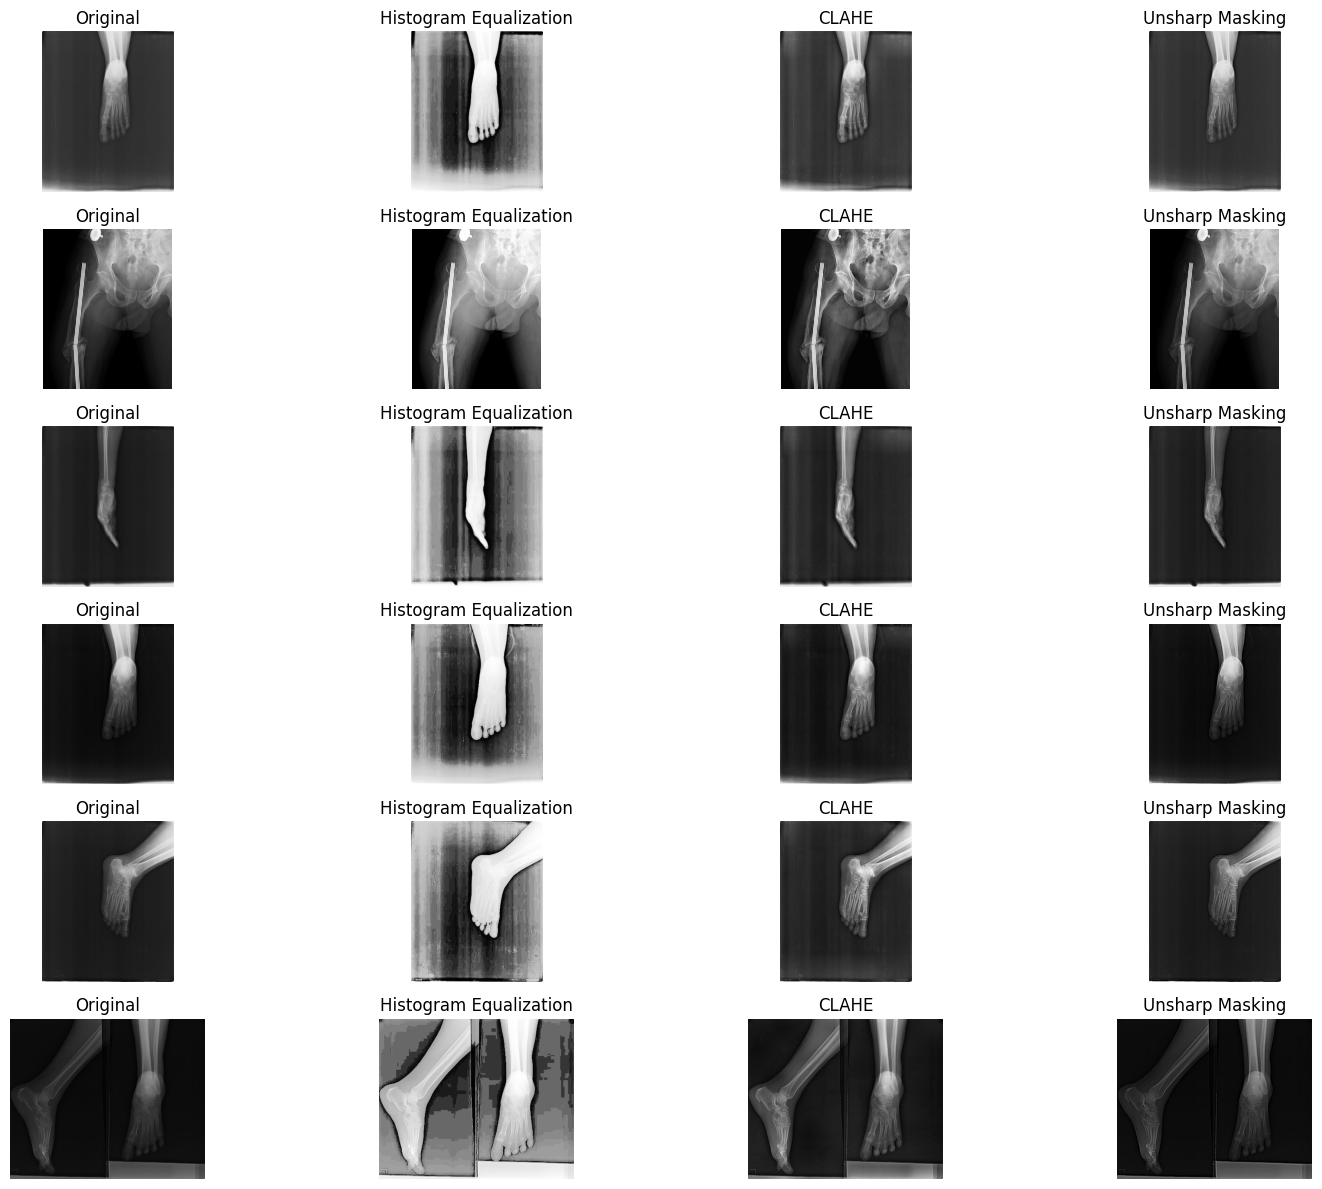

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Load a few random images from the dataset
num_samples = 6  # Increase number of images displayed
sample_images = random.sample(list(train_dataset.data["image_path"]), num_samples)

# Function to plot images
def plot_comparisons(image_paths):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 12))  # Increase figure size

    for i, img_path in enumerate(image_paths):
        # Load the original image
        original = Image.open(img_path).convert("RGB")

        # Apply transformations
        hist_eq = apply_histogram_equalization(original)
        clahe = apply_clahe(original)
        unsharp = apply_unsharp_masking(original)

        # Plot images
        axes[i, 0].imshow(original)
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(hist_eq)
        axes[i, 1].set_title("Histogram Equalization")
        axes[i, 2].imshow(clahe)
        axes[i, 2].set_title("CLAHE")
        axes[i, 3].imshow(unsharp)
        axes[i, 3].set_title("Unsharp Masking")

        # Hide axis labels
        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Display comparisons
plot_comparisons(sample_images)

# Implementing Learning Rate Scheduling with ReduceLROnPlateau

We enhance our training process by integrating the ReduceLROnPlateau scheduler, which dynamically adjusts the learning rate based on validation loss trends. This approach helps prevent the model from getting stuck in local minima and promotes better convergence.

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# Define a function to train EfficientNet with learning rate scheduling
def train_model_with_scheduler(model, optimizer, train_loader, test_loader, num_epochs, model_name, lr):
    model.to(device)
    best_f1 = 0  # Track best F1-score
    history = []  # Store training history

    # Initialize Learning Rate Scheduler (Reduce LR if val loss stops improving)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update tqdm description with live loss value
            progress_bar.set_postfix(loss=loss.item())

        # Compute training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average="weighted")

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(test_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average="weighted")

        print(f"Epoch {epoch}/{num_epochs} | Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

        # Adjust LR if validation loss does not improve
        scheduler.step(val_loss)

        # Save training history
        history.append([epoch, val_loss, val_acc, val_f1])

        # Save final model
        if epoch == num_epochs:
            checkpoint_path = os.path.join(save_dir, f"{model_name}_lr{lr}_final.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Final model saved: {checkpoint_path}")

    return history

# Initialize save directory
save_dir = "/content/drive/MyDrive/FracAtlas/models"

# Retrain EfficientNet on each transformation using LR scheduler
train_histories_adv = {}

for name, dataloader in dataloaders.items():
    print(f"\n🔄 Training EfficientNet with {name.upper()} transformations using LR Scheduler...")

    # Define model and optimizer
    efficientnet_model = get_model("efficientnet")
    optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)

    # Train model
    history = train_model_with_scheduler(efficientnet_model, optimizer, dataloader, test_loader, 20, f"efficientnet_{name}", 0.0001)
    train_histories_adv[name] = history

print("✅ Training with advanced transformations and LR scheduler complete!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔄 Training EfficientNet with HIST_EQ transformations using LR Scheduler...


Epoch 1/20: 100%|██████████| 142/142 [00:27<00:00,  5.13it/s, loss=0.714]


Epoch 1/20 | Loss: 0.6029 | Acc: 0.6725 | F1: 0.6699


Epoch 2/20: 100%|██████████| 142/142 [00:26<00:00,  5.34it/s, loss=0.666]


Epoch 2/20 | Loss: 0.5701 | Acc: 0.7073 | F1: 0.7066


Epoch 3/20: 100%|██████████| 142/142 [00:25<00:00,  5.50it/s, loss=0.646]


Epoch 3/20 | Loss: 0.5702 | Acc: 0.6864 | F1: 0.6818


Epoch 4/20: 100%|██████████| 142/142 [00:26<00:00,  5.37it/s, loss=0.539]


Epoch 4/20 | Loss: 0.5505 | Acc: 0.6899 | F1: 0.6861


Epoch 5/20: 100%|██████████| 142/142 [00:26<00:00,  5.32it/s, loss=0.433]


Epoch 5/20 | Loss: 0.5314 | Acc: 0.7317 | F1: 0.7312


Epoch 6/20: 100%|██████████| 142/142 [00:27<00:00,  5.22it/s, loss=0.763]


Epoch 6/20 | Loss: 0.5577 | Acc: 0.7422 | F1: 0.7418


Epoch 7/20: 100%|██████████| 142/142 [00:26<00:00,  5.34it/s, loss=0.666]


Epoch 7/20 | Loss: 0.6225 | Acc: 0.7352 | F1: 0.7345


Epoch 8/20: 100%|██████████| 142/142 [00:25<00:00,  5.54it/s, loss=0.835]


Epoch 8/20 | Loss: 0.5969 | Acc: 0.7456 | F1: 0.7452


Epoch 9/20: 100%|██████████| 142/142 [00:26<00:00,  5.38it/s, loss=0.29]


Epoch 9/20 | Loss: 0.5276 | Acc: 0.7422 | F1: 0.7421


Epoch 10/20: 100%|██████████| 142/142 [00:26<00:00,  5.30it/s, loss=0.419]


Epoch 10/20 | Loss: 0.6305 | Acc: 0.7317 | F1: 0.7288


Epoch 11/20: 100%|██████████| 142/142 [00:26<00:00,  5.32it/s, loss=0.201]


Epoch 11/20 | Loss: 0.5908 | Acc: 0.7387 | F1: 0.7380


Epoch 12/20: 100%|██████████| 142/142 [00:26<00:00,  5.32it/s, loss=0.168]


Epoch 12/20 | Loss: 0.6035 | Acc: 0.7317 | F1: 0.7316


Epoch 13/20: 100%|██████████| 142/142 [00:25<00:00,  5.50it/s, loss=0.235]


Epoch 13/20 | Loss: 0.6812 | Acc: 0.7352 | F1: 0.7350


Epoch 14/20: 100%|██████████| 142/142 [00:26<00:00,  5.36it/s, loss=0.126]


Epoch 14/20 | Loss: 0.6213 | Acc: 0.7282 | F1: 0.7281


Epoch 15/20: 100%|██████████| 142/142 [00:26<00:00,  5.30it/s, loss=0.101]


Epoch 15/20 | Loss: 0.6300 | Acc: 0.7213 | F1: 0.7209


Epoch 16/20: 100%|██████████| 142/142 [00:26<00:00,  5.35it/s, loss=0.421]


Epoch 16/20 | Loss: 0.6790 | Acc: 0.7178 | F1: 0.7172


Epoch 17/20: 100%|██████████| 142/142 [00:26<00:00,  5.29it/s, loss=0.0903]


Epoch 17/20 | Loss: 0.7011 | Acc: 0.7213 | F1: 0.7210


Epoch 18/20: 100%|██████████| 142/142 [00:25<00:00,  5.54it/s, loss=0.205]


Epoch 18/20 | Loss: 0.7089 | Acc: 0.7108 | F1: 0.7105


Epoch 19/20: 100%|██████████| 142/142 [00:26<00:00,  5.35it/s, loss=0.153]


Epoch 19/20 | Loss: 0.6828 | Acc: 0.7143 | F1: 0.7143


Epoch 20/20: 100%|██████████| 142/142 [00:26<00:00,  5.32it/s, loss=0.156]


Epoch 20/20 | Loss: 0.6693 | Acc: 0.7108 | F1: 0.7107
✅ Final model saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_hist_eq_lr0.0001_final.pth

🔄 Training EfficientNet with CLAHE transformations using LR Scheduler...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 142/142 [00:30<00:00,  4.72it/s, loss=0.725]


Epoch 1/20 | Loss: 0.5608 | Acc: 0.7073 | F1: 0.7004


Epoch 2/20: 100%|██████████| 142/142 [00:30<00:00,  4.70it/s, loss=0.622]


Epoch 2/20 | Loss: 0.5378 | Acc: 0.7422 | F1: 0.7377


Epoch 3/20: 100%|██████████| 142/142 [00:30<00:00,  4.69it/s, loss=0.841]


Epoch 3/20 | Loss: 0.5235 | Acc: 0.7631 | F1: 0.7598


Epoch 4/20: 100%|██████████| 142/142 [00:30<00:00,  4.71it/s, loss=0.674]


Epoch 4/20 | Loss: 0.5507 | Acc: 0.7491 | F1: 0.7461


Epoch 5/20: 100%|██████████| 142/142 [00:30<00:00,  4.70it/s, loss=0.743]


Epoch 5/20 | Loss: 0.4822 | Acc: 0.8049 | F1: 0.8047


Epoch 6/20: 100%|██████████| 142/142 [00:30<00:00,  4.67it/s, loss=0.478]


Epoch 6/20 | Loss: 0.5995 | Acc: 0.7909 | F1: 0.7907


Epoch 7/20: 100%|██████████| 142/142 [00:30<00:00,  4.72it/s, loss=0.619]


Epoch 7/20 | Loss: 0.5726 | Acc: 0.7805 | F1: 0.7803


Epoch 8/20: 100%|██████████| 142/142 [00:30<00:00,  4.60it/s, loss=0.722]


Epoch 8/20 | Loss: 0.5792 | Acc: 0.7875 | F1: 0.7873


Epoch 9/20: 100%|██████████| 142/142 [00:30<00:00,  4.73it/s, loss=0.375]


Epoch 9/20 | Loss: 0.6361 | Acc: 0.7979 | F1: 0.7978


Epoch 10/20: 100%|██████████| 142/142 [00:31<00:00,  4.50it/s, loss=0.222]


Epoch 10/20 | Loss: 0.7154 | Acc: 0.7700 | F1: 0.7697


Epoch 11/20: 100%|██████████| 142/142 [00:30<00:00,  4.73it/s, loss=0.58]


Epoch 11/20 | Loss: 0.6586 | Acc: 0.7840 | F1: 0.7837


Epoch 12/20: 100%|██████████| 142/142 [00:31<00:00,  4.52it/s, loss=0.0846]


Epoch 12/20 | Loss: 0.6760 | Acc: 0.7909 | F1: 0.7905


Epoch 13/20: 100%|██████████| 142/142 [00:30<00:00,  4.72it/s, loss=0.115]


Epoch 13/20 | Loss: 0.7548 | Acc: 0.7805 | F1: 0.7805


Epoch 14/20: 100%|██████████| 142/142 [00:31<00:00,  4.51it/s, loss=0.0819]


Epoch 14/20 | Loss: 0.6817 | Acc: 0.8014 | F1: 0.8014


Epoch 15/20: 100%|██████████| 142/142 [00:30<00:00,  4.73it/s, loss=0.236]


Epoch 15/20 | Loss: 0.6751 | Acc: 0.8118 | F1: 0.8117


Epoch 16/20: 100%|██████████| 142/142 [00:31<00:00,  4.49it/s, loss=0.0661]


Epoch 16/20 | Loss: 0.6527 | Acc: 0.8014 | F1: 0.8012


Epoch 17/20: 100%|██████████| 142/142 [00:30<00:00,  4.68it/s, loss=0.0572]


Epoch 17/20 | Loss: 0.6912 | Acc: 0.7979 | F1: 0.7978


Epoch 18/20: 100%|██████████| 142/142 [00:31<00:00,  4.50it/s, loss=0.141]


Epoch 18/20 | Loss: 0.6928 | Acc: 0.8084 | F1: 0.8084


Epoch 19/20: 100%|██████████| 142/142 [00:30<00:00,  4.70it/s, loss=0.271]


Epoch 19/20 | Loss: 0.7047 | Acc: 0.8188 | F1: 0.8188


Epoch 20/20: 100%|██████████| 142/142 [00:31<00:00,  4.51it/s, loss=0.0689]


Epoch 20/20 | Loss: 0.7075 | Acc: 0.8188 | F1: 0.8187
✅ Final model saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_clahe_lr0.0001_final.pth

🔄 Training EfficientNet with UNSHARP transformations using LR Scheduler...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 142/142 [00:30<00:00,  4.61it/s, loss=0.786]


Epoch 1/20 | Loss: 0.5601 | Acc: 0.7456 | F1: 0.7446


Epoch 2/20: 100%|██████████| 142/142 [00:32<00:00,  4.37it/s, loss=0.782]


Epoch 2/20 | Loss: 0.5180 | Acc: 0.7317 | F1: 0.7317


Epoch 3/20: 100%|██████████| 142/142 [00:31<00:00,  4.58it/s, loss=0.657]


Epoch 3/20 | Loss: 0.5458 | Acc: 0.7352 | F1: 0.7346


Epoch 4/20: 100%|██████████| 142/142 [00:31<00:00,  4.50it/s, loss=0.509]


Epoch 4/20 | Loss: 0.5908 | Acc: 0.7631 | F1: 0.7620


Epoch 5/20: 100%|██████████| 142/142 [00:30<00:00,  4.61it/s, loss=0.834]


Epoch 5/20 | Loss: 0.5495 | Acc: 0.7491 | F1: 0.7489


Epoch 6/20: 100%|██████████| 142/142 [00:30<00:00,  4.60it/s, loss=0.593]


Epoch 6/20 | Loss: 0.6000 | Acc: 0.7561 | F1: 0.7560


Epoch 7/20: 100%|██████████| 142/142 [00:31<00:00,  4.54it/s, loss=0.65]


Epoch 7/20 | Loss: 0.7891 | Acc: 0.7666 | F1: 0.7658


Epoch 8/20: 100%|██████████| 142/142 [00:31<00:00,  4.53it/s, loss=0.323]


Epoch 8/20 | Loss: 0.6593 | Acc: 0.7666 | F1: 0.7656


Epoch 9/20: 100%|██████████| 142/142 [00:32<00:00,  4.40it/s, loss=0.274]


Epoch 9/20 | Loss: 0.6581 | Acc: 0.7805 | F1: 0.7805


Epoch 10/20: 100%|██████████| 142/142 [00:31<00:00,  4.58it/s, loss=0.283]


Epoch 10/20 | Loss: 0.7306 | Acc: 0.7770 | F1: 0.7752


Epoch 11/20: 100%|██████████| 142/142 [00:32<00:00,  4.37it/s, loss=0.251]


Epoch 11/20 | Loss: 0.7059 | Acc: 0.7979 | F1: 0.7975


Epoch 12/20: 100%|██████████| 142/142 [00:30<00:00,  4.61it/s, loss=0.393]


Epoch 12/20 | Loss: 0.6922 | Acc: 0.7944 | F1: 0.7934


Epoch 13/20: 100%|██████████| 142/142 [00:31<00:00,  4.45it/s, loss=0.268]


Epoch 13/20 | Loss: 0.6672 | Acc: 0.8049 | F1: 0.8044


Epoch 14/20: 100%|██████████| 142/142 [00:30<00:00,  4.61it/s, loss=0.195]


Epoch 14/20 | Loss: 0.7613 | Acc: 0.7770 | F1: 0.7757


Epoch 15/20: 100%|██████████| 142/142 [00:31<00:00,  4.54it/s, loss=0.308]


Epoch 15/20 | Loss: 0.6645 | Acc: 0.8049 | F1: 0.8047


Epoch 16/20: 100%|██████████| 142/142 [00:30<00:00,  4.59it/s, loss=0.0764]


Epoch 16/20 | Loss: 0.7190 | Acc: 0.7944 | F1: 0.7942


Epoch 17/20: 100%|██████████| 142/142 [00:31<00:00,  4.54it/s, loss=0.0878]


Epoch 17/20 | Loss: 0.6605 | Acc: 0.7944 | F1: 0.7944


Epoch 18/20: 100%|██████████| 142/142 [00:32<00:00,  4.32it/s, loss=0.161]


Epoch 18/20 | Loss: 0.6848 | Acc: 0.8049 | F1: 0.8047


Epoch 19/20: 100%|██████████| 142/142 [00:31<00:00,  4.57it/s, loss=0.252]


Epoch 19/20 | Loss: 0.7117 | Acc: 0.8084 | F1: 0.8079


Epoch 20/20: 100%|██████████| 142/142 [00:32<00:00,  4.35it/s, loss=0.0746]


Epoch 20/20 | Loss: 0.6905 | Acc: 0.8084 | F1: 0.8080
✅ Final model saved: /content/drive/MyDrive/FracAtlas/models/efficientnet_unsharp_lr0.0001_final.pth
✅ Training with advanced transformations and LR scheduler complete!


# Final Results

In [ ]:
import pandas as pd
from IPython.display import display

# Extract final epoch results for each transformation
comparison_data = {
    "Transformation": list(train_histories_adv.keys()),  # Transformation names
    "Final Val Loss": [history[-1][1] for history in train_histories_adv.values()],  # Last epoch validation loss
    "Final Val Acc": [history[-1][2] for history in train_histories_adv.values()],  # Last epoch accuracy
    "Final Val F1": [history[-1][3] for history in train_histories_adv.values()]  # Last epoch F1-score
}

# Create DataFrame for comparison
df_comparison = pd.DataFrame(comparison_data)

# Display the comparison table
display(df_comparison)

,Transformation,Final Val Loss,Final Val Acc,Final Val F1
0,hist_eq,0.669270,0.710801,0.710731
1,clahe,0.707513,0.818815,0.818749
2,unsharp,0.690544,0.808362,0.807999
